# Energy Star Project
## Predict 1-to-100 percentile ranking relative measure used for comparing the energy efficiency of buildings based on self-reported energy usage.
### Ref : https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

## Load Data

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv'
data = pd.read_csv(PATH)

## Data Cleaning (Missing Data)

In [0]:
# Convert missing value to NaN
data = data.replace('Not Available', np.nan)

for col in data.columns.to_list():
    if 'ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col or 'therms' in col or 'gal' in col or 'Score' in col:
        data[col] = data[col].astype(np.float)

In [0]:
# Find columns with >50% missing data
mis_val_percent = data.isnull().sum(axis=0) / len(data) * 100
mis_val_percent_df = pd.DataFrame(mis_val_percent)
mis_cols = mis_val_percent_df[mis_val_percent_df[0] > 50].index

In [0]:
# Drop columns with >50% missing data
data = data.drop(columns=mis_cols)

## Data Cleaning (Remove Outliers)

In [0]:
# Remove extreme outlider
# 1st quantile - 3 * interquantile range
# 3rd quantile + 3 * interquantile range
for col in data.describe().columns:
    # Statistics
    first_qt = data[col].describe()['25%']
    third_qt = data[col].describe()['75%']
    iqr = max(third_qt - first_qt, 1)       # Avoid 0 for Number of Buildings - Self-reported

    # Remove outlier
    data = data[(data[col] >= (first_qt - 3 * iqr)) & (data[col] <= (third_qt + 3 * iqr))]

## Exploratory Data Analysis (Histogram)

Text(0.5, 1.0, 'Energy Star Score Distribution')

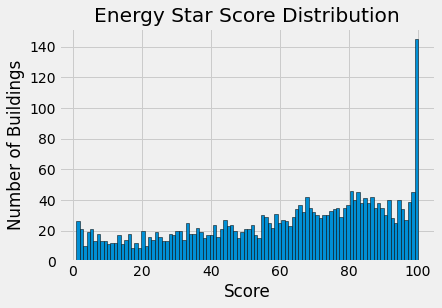

In [139]:
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
_ = plt.hist(data['ENERGY STAR Score'].dropna(), bins=100, edgecolor='k')
plt.xlabel('Score')
plt.ylabel('Number of Buildings')
plt.title('Energy Star Score Distribution')

Text(0.5, 1.0, 'Density Plot of Energy Star Scores by Building Type')

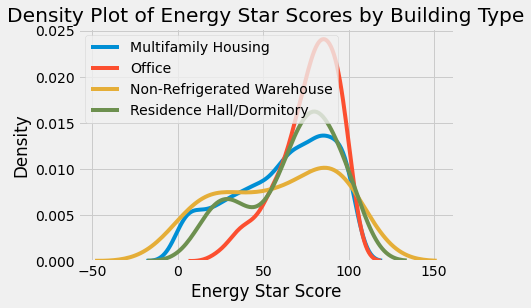

In [140]:
# Looking for Relationships (Score vs Building Type)
types = data.dropna(subset=['ENERGY STAR Score'])           # Drop rows with missing score
types = types['Largest Property Use Type'].value_counts()   # Count data size for each type
types = list(types[types.values > 30].index)                # Keep only >30 types

for b_type in types:
    data_sub = data[data['Largest Property Use Type'] == b_type]
    sns.kdeplot(data_sub['ENERGY STAR Score'].dropna(), label = b_type, shade = False);

plt.xlabel('Energy Star Score')
plt.ylabel('Density') 
plt.title('Density Plot of Energy Star Scores by Building Type')

## Exploratory Data Analysis (Correlation)

In [141]:
# Find correlation between score and other features
data.corr()['ENERGY STAR Score'].sort_values().head(3)

Weather Normalized Source EUI (kBtu/ft²)   -0.745284
Source EUI (kBtu/ft²)                      -0.742357
Site EUI (kBtu/ft²)                        -0.706328
Name: ENERGY STAR Score, dtype: float64

## Exploratory Data Analysis (Pair Plot)

In [0]:
# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

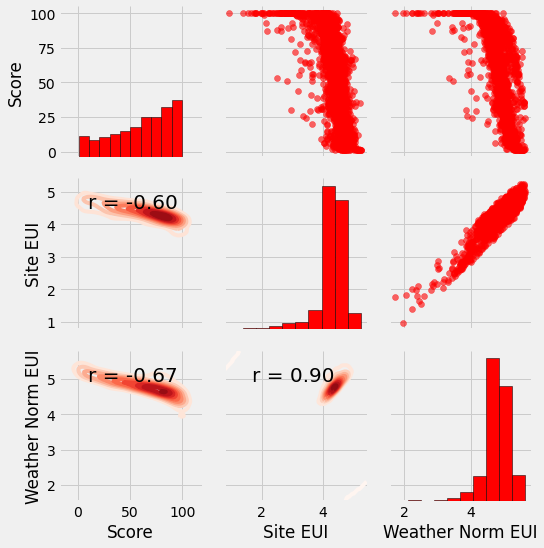

In [143]:
# Extract the columns to  plot
plot_data = data[['ENERGY STAR Score', 'Site EUI (kBtu/ft²)', 
                  'Weather Normalized Source EUI (kBtu/ft²)']]
plot_data = plot_data.rename(columns = {'ENERGY STAR Score': 'Score',
                                        'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI'})
plot_data['Site EUI'] = np.log(plot_data['Site EUI'])
plot_data['Weather Norm EUI'] = np.log(plot_data['Weather Norm EUI'])
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data.dropna())

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

## Feature Preprocessing

In [144]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = features.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col != 'ENERGY STAR Score':
        numeric_subset['log_' + col] = np.log(np.maximum(numeric_subset[col], 1e-6))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [0]:
# Select the categorical columns
categorical_subset = features[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

In [0]:
# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

## Feature Selection (Remove collinear features)

In [0]:
# Threshold for collinear features
threshold = 0.6

In [161]:
# Extract target
targets = features['ENERGY STAR Score']
features_sel = features.drop(columns=['ENERGY STAR Score'])

# Calculate the correlation matrix
corr_matrix = features_sel.corr()
drop_cols = []

# Iterate through the correlation matrix and compare correlations
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
        col = item.columns
        row = item.index
        val = abs(item.values)
        
        # If correlation exceeds the threshold
        if val >= threshold:
            # Print the correlated features and the correlation value
            drop_cols.append(col.values[0])

# Drop one of each pair of correlated columns
drops = set(drop_cols)
features_sel = features_sel.drop(columns=drops)

# Add the score back in to the data
features_sel['ENERGY STAR Score'] = targets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


## Split Dataset

In [0]:
# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features_sel, targets, 
                                        test_size = 0.3, 
                                        random_state = 42)

## Baseline (Median Value)

In [0]:
baseline_guess = np.median(y)

## SVM

In [197]:
model = SVR(verbose=True)
model.fit(X, y)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [0]:
svm_pred = model.predict(X_test)

## Evaluation

In [0]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [167]:
# Baseline
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 67.00
Baseline Performance on the test set: MAE = 23.6008


In [199]:
# SVM
print('SVM Performance on the test set: MAE = %0.4f' % mae(y_test, svm_pred))

SVM Performance on the test set: MAE = 23.5280
